<a href="https://colab.research.google.com/github/ipavlopoulos/proverbs.gr/blob/main/bert-gr-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

i = 2
seed = 2023+i
balanced_corpus = pd.read_csv("https://raw.githubusercontent.com/ipavlopoulos/paremia/main/data/balanced_corpus.csv", index_col=0)
train, test = train_test_split(balanced_corpus, test_size=0.05, random_state=seed)
train, dev = train_test_split(train, test_size=test.shape[0], random_state=seed)

In [26]:
!pip install transformers
from transformers import BertModel, BertTokenizer
model_name = 'nlpaueb/bert-base-greek-uncased-v1'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [27]:
import torch
import numpy as np

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, max_length = 32):
        self.max_length = max_length
        self.labels = df[["lat", "lon"]].values
        self.texts = df.text.apply(lambda txt: tokenizer(txt,
                                                         padding='max_length',
                                                         max_length = self.max_length,
                                                         truncation=True,
                                                         return_tensors="pt")).values

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

In [28]:
from torch import nn

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.1, num_classes=2):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.linear1 = nn.Linear(768, 128, bias=True)
        self.norm = nn.BatchNorm1d(128)
        self.linear2 = nn.Linear(128, num_classes, bias=True)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        x = pooled_output
        x = self.dropout(x)
        x = self.relu(self.linear1(x))
        x = self.norm(x)
        x = self.linear2(x)
        return x

In [29]:
from torch.optim import Adam
from tqdm import tqdm

from transformers import AutoTokenizer, BertModel

def validate(model, dataloader, device="cpu", criterion=nn.MSELoss()):
    predictions, gold_labels = [], []
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_batch_id, (val_input, val_label) in enumerate(dataloader):
            val_label = val_label.to(device)
            mask = val_input['attention_mask'].to(device)
            input_id = val_input['input_ids'].squeeze(1).to(device)
            output = model(input_id, mask)
            val_batch_loss = criterion(output, val_label)
            predictions.extend(output.cpu().numpy())
            gold_labels.extend(val_label.cpu())
            val_loss += val_batch_loss.item()
    return predictions, gold_labels, val_loss/val_batch_id

def finetune(model, train_data, val_data,
             learning_rate=2e-5, epochs=100, criterion=nn.MSELoss(),
             batch_size=32, max_length=16, patience=5):

    train_losses = []
    val_losses = []

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, drop_last=False)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    optimizer = Adam(model.parameters(), lr=learning_rate)
    model.train()
    lowest_loss = 1000
    best_epoch = 0
    epochs_not_improving = 0

    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):
            total_acc_train = 0
            total_loss_train = 0
            total_loss_val = 0
            for batch_id, (train_input, train_label) in tqdm(enumerate(train_dataloader)):
                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)
                output = model(input_id, mask)
                batch_loss = criterion(output, train_label.float())
                total_loss_train += batch_loss.item()
                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            train_losses.append(total_loss_train/(batch_id+1))

            predictions, gold_labels, val_loss = validate(model, val_dataloader, device, criterion)
            val_losses.append(val_loss)
            if val_loss < lowest_loss:
                print(f"New best epoch found: {epoch_num} (val loss: {val_loss:.3f})!")
                lowest_loss = val_loss
                best_epoch = epoch_num
                torch.save(model.state_dict(), "checkpoint.pt")
                epochs_not_improving = 0
            else:
                epochs_not_improving += 1
                if epochs_not_improving >= patience:
                    model.load_state_dict(torch.load("checkpoint.pt"))
                    print('Patience is up, restoring the best model and exiting...')
                    break

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/batch_id: .3f} \
                | Val Loss: {val_loss: .3f} (best epoch: {best_epoch} w/val_loss: {lowest_loss:.3f})')
    model.eval()
    return model, train_losses, val_losses

In [30]:
criterion = nn.MSELoss()
model = BertClassifier(num_classes=2)
max_length = 32

model, train_losses, val_losses = finetune(model,
                                           Dataset(train, max_length=max_length),
                                           Dataset(dev, max_length=max_length),
                                           epochs=100,
                                           max_length=max_length,
                                           learning_rate=2e-5,
                                           criterion=criterion)

324it [00:58,  5.59it/s]


Epochs: 1 | Train Loss:  1034.457                 | Val Loss:  1084.003 (best epoch: 0 w/val_loss: 1000.000)


324it [01:01,  5.27it/s]


New best epoch found: 1 (val loss: 4.160)!
Epochs: 2 | Train Loss:  18.935                 | Val Loss:  4.160 (best epoch: 1 w/val_loss: 4.160)


324it [01:00,  5.31it/s]


New best epoch found: 2 (val loss: 4.000)!
Epochs: 3 | Train Loss:  4.462                 | Val Loss:  4.000 (best epoch: 2 w/val_loss: 4.000)


324it [01:01,  5.29it/s]


New best epoch found: 3 (val loss: 3.819)!
Epochs: 4 | Train Loss:  3.862                 | Val Loss:  3.819 (best epoch: 3 w/val_loss: 3.819)


324it [01:01,  5.31it/s]


New best epoch found: 4 (val loss: 3.482)!
Epochs: 5 | Train Loss:  3.362                 | Val Loss:  3.482 (best epoch: 4 w/val_loss: 3.482)


324it [01:01,  5.29it/s]


Epochs: 6 | Train Loss:  2.770                 | Val Loss:  4.027 (best epoch: 4 w/val_loss: 3.482)


324it [01:01,  5.31it/s]


Epochs: 7 | Train Loss:  2.040                 | Val Loss:  3.590 (best epoch: 4 w/val_loss: 3.482)


324it [01:01,  5.28it/s]


Epochs: 8 | Train Loss:  1.290                 | Val Loss:  3.838 (best epoch: 4 w/val_loss: 3.482)


324it [01:01,  5.30it/s]


Epochs: 9 | Train Loss:  0.775                 | Val Loss:  3.849 (best epoch: 4 w/val_loss: 3.482)


324it [01:01,  5.29it/s]


Patience is up, restoring the best model and exiting...


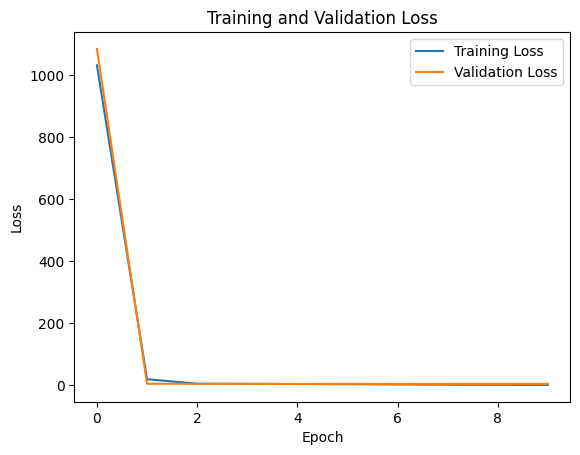

In [31]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend();

In [32]:
test_dataloader = torch.utils.data.DataLoader(Dataset(test, max_length=max_length), batch_size=32, drop_last=False)
p,l,_ = validate(model.to("cpu"), test_dataloader, "cpu", criterion)
preds_pd = pd.DataFrame({"pred_lat": np.array(p)[:, 0], "pred_lon": np.array(p)[:, 1],
                         "gold_lat": np.array([i.numpy() for i in l])[:, 0],
                         "gold_lon": np.array([i.numpy() for i in l])[:, 1]})
preds_pd.to_csv(f"proverb.predictions_s{i}.csv", index=False)

In [33]:
print('MAE')
print(f"lat: {mean_absolute_error(preds_pd.pred_lat, preds_pd.gold_lat):.2f}")
print(f"lon: {mean_absolute_error(preds_pd.pred_lon, preds_pd.gold_lon):.2f}")
print('MSE')
print(f"lat: {mean_squared_error(preds_pd.pred_lat, preds_pd.gold_lat):.2f}")
print(f"lon: {mean_squared_error(preds_pd.pred_lon, preds_pd.gold_lon):.2f}")
print('R2')
print(f"lat: {r2_score(preds_pd.pred_lat, preds_pd.gold_lat):.2f}")
print(f"lon: {r2_score(preds_pd.pred_lon, preds_pd.gold_lon):.2f}")

MAE
lat: 1.27
lon: 1.89
MSE
lat: 2.59
lon: 6.08
R2
lat: -3.58
lon: -0.66


In [34]:
torch.save(model.state_dict(), f"bert-gr-r-s{i}.pt")

In [35]:
#from google.colab import auth
#auth.authenticate_user()
project_id = 'TBD'
bucket_name = 'TBD'
model_name = f"bert-gr-r-s{i}.pt"
!gcloud config set project {project_id}
!gsutil cp {model_name} gs://{bucket_name}/ # up

Updated property [core/project].
Copying file://bert-gr-r-s2.pt [Content-Type=application/vnd.snesdev-page-table]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

| [1 files][431.2 MiB/431.2 MiB]                                                
Operation completed over 1 objects/431.2 MiB.                                    


# Assessment

In [ ]:
# to use these, initialise the bucket_name and project_id
project_id = 'TBD' # <== set these properly
!gcloud config set project {project_id}
!gsutil cp 'gs://THE_BUCKET/bert-gr-c-seed0.pt' ./
!gsutil cp 'gs://THE_BUCKET/bert-gr-c-seed1.pt' ./
!gsutil cp 'gs://THE_BUCKET/bert-gr-c-seed2.pt' ./

In [41]:
scores = {'mae': {'lat':[], 'lon':[]},
          'mse': {'lat':[], 'lon':[]}}
for i in range(3): # three models are trained with seed from 2023 to 2025
  seed = 2023+i
  train, test = train_test_split(balanced_corpus, test_size=0.05, random_state=seed)
  train, dev = train_test_split(train, test_size=test.shape[0], random_state=seed)
  test_dataloader = torch.utils.data.DataLoader(Dataset(test, max_length=max_length), batch_size=32, drop_last=False)
  model.load_state_dict(torch.load(f"bert-gr-r-s{i}.pt"))
  p,l,_ = validate(model.to("cpu"), test_dataloader, "cpu", criterion)
  preds_pd = pd.DataFrame({"pred_lat": np.array(p)[:, 0], "pred_lon": np.array(p)[:, 1],
                           "gold_lat": np.array([i.numpy() for i in l])[:, 0],
                           "gold_lon": np.array([i.numpy() for i in l])[:, 1]})
  scores['mae']['lat'].append(mean_absolute_error(preds_pd.pred_lat, preds_pd.gold_lat))
  scores['mae']['lon'].append(mean_absolute_error(preds_pd.pred_lon, preds_pd.gold_lon))
  scores['mse']['lat'].append(mean_squared_error(preds_pd.pred_lat, preds_pd.gold_lat))
  scores['mse']['lon'].append(mean_squared_error(preds_pd.pred_lon, preds_pd.gold_lon))

In [45]:
for e in ('mae', 'mse'):
  for l in ('lat', 'lon'):
    print(e, l, pd.Series(scores[e][l]).agg(['mean', 'sem']))

mae lat mean    1.328482
sem     0.037338
dtype: float64
mae lon mean    1.806833
sem     0.041383
dtype: float64
mse lat mean    2.701287
sem     0.079878
dtype: float64
mse lon mean    5.343756
sem     0.372213
dtype: float64
